In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_columns import childhood, demographic, diagnosis, all
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

In [49]:
init_df = pd.read_csv('./data/filtered_mental_health_data.csv')
df = init_df.copy()
df_filtered = df[df.columns[~df.columns.str.match(r'^(D_|DSM_)')]]
df_filtered.shape

(5001, 552)

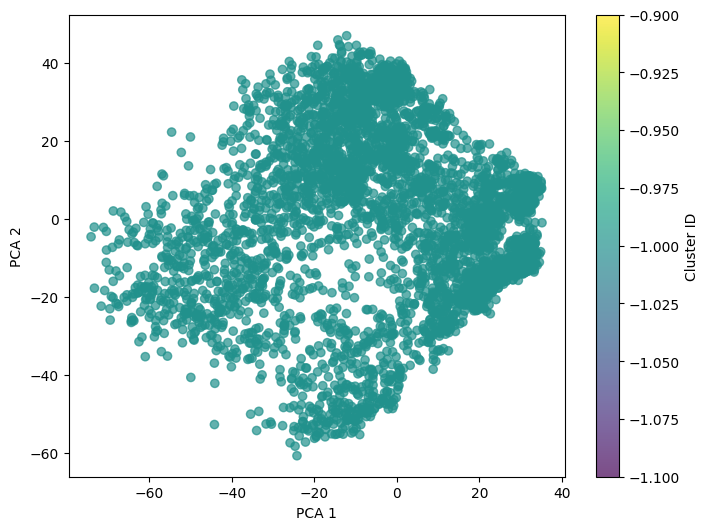

In [50]:
dbscan_df = df_filtered.copy()
dbscan = DBSCAN(eps=.7, min_samples=10)
labels_db = dbscan.fit_predict(dbscan_df)

pca3 = PCA(n_components=2) 
X_pca = pca3.fit_transform(dbscan_df)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db, cmap="viridis", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.show()


/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


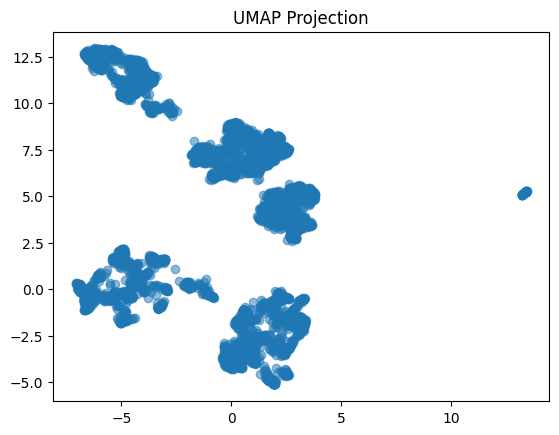

In [51]:

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df_filtered)

plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection")
plt.show()

/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/samroska/github/milestone-2-siads-696/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


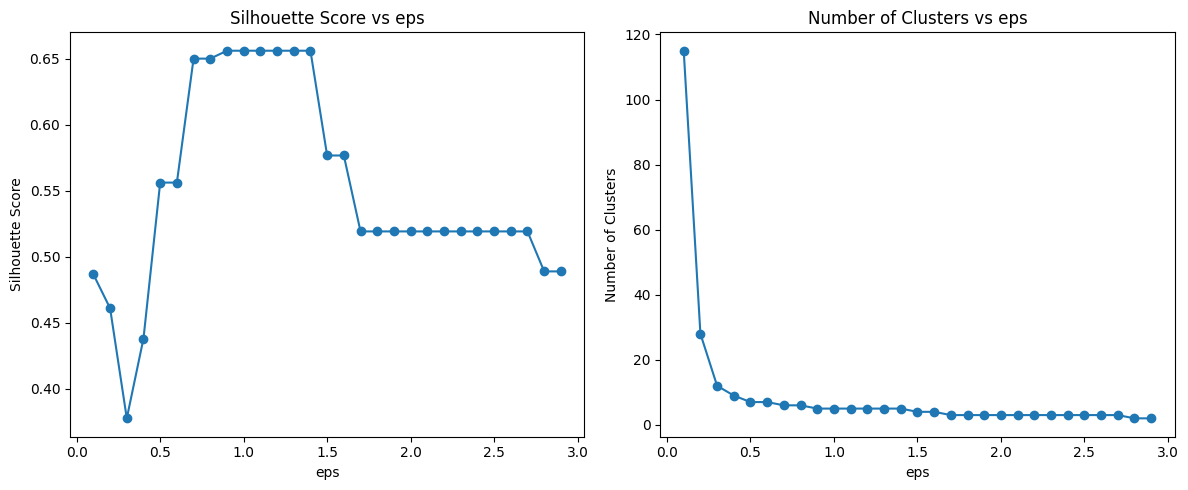

In [52]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_filtered)

eps_values = np.arange(0.1, 3.0, 0.1)
silhouette_scores = []
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_umap)

    if len(set(labels)) > 1 and len(set(labels)) < len(X_umap):
        score = silhouette_score(X_umap[labels != -1], labels[labels != -1])
    else:
        score = -1 

    silhouette_scores.append(score)
    n_clusters_list.append(len(set(labels)) - (1 if -1 in labels else 0))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eps_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs eps')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title('Number of Clusters vs eps')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')

plt.tight_layout()
plt.show()

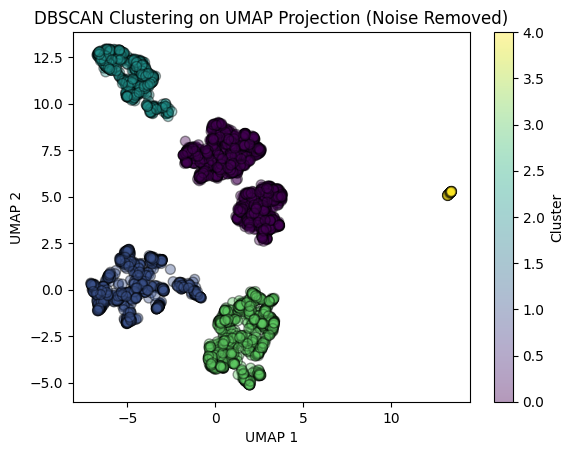

In [53]:
dbscan5 = DBSCAN(eps=.9, min_samples=5)
labels5 = dbscan5.fit_predict(X_umap)

mask = labels5 != -1
X_umap_filtered5 = X_umap[mask]
labels5_filtered = labels5[mask]

plt.scatter(X_umap_filtered5[:, 0], X_umap_filtered5[:, 1], c=labels5_filtered, cmap='viridis', s=50, alpha=0.4, edgecolor='k',label='Data Points')
plt.title("DBSCAN Clustering on UMAP Projection (Noise Removed)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [54]:
sil_coeff = silhouette_score(X_umap,labels5)
print("Silhouette Coefficient:", round(sil_coeff, 3))

score = davies_bouldin_score(X_umap, labels5)
print("Davis - Bouldin score:",score)

Silhouette Coefficient: 0.656
Davis - Bouldin score: 0.413903338825423


In [55]:
eps_values = np.linspace(0.1, 2.0, 20)  # adjust range to your dataset
results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10).fit(X_umap)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        sil = silhouette_score(X_umap, labels)
        dbi = davies_bouldin_score(X_umap, labels)
    else:
        sil = np.nan
        dbi = np.nan
    
    results.append((eps, n_clusters, sil, dbi))

df_results = pd.DataFrame(results, columns=['eps', 'n_clusters', 'silhouette', 'davies_bouldin'])
print(df_results)

    eps  n_clusters  silhouette  davies_bouldin
0   0.1          92    0.190678        1.151192
1   0.2          40    0.360525        1.301034
2   0.3          15    0.371888        1.656193
3   0.4          10    0.430487        1.058515
4   0.5           7    0.510938        0.497741
5   0.6           7    0.510938        0.497741
6   0.7           6    0.650285        0.444650
7   0.8           6    0.650285        0.444650
8   0.9           5    0.656277        0.413903
9   1.0           5    0.656277        0.413903
10  1.1           5    0.656277        0.413903
11  1.2           5    0.656277        0.413903
12  1.3           5    0.656277        0.413903
13  1.4           5    0.656277        0.413903
14  1.5           4    0.576867        0.529511
15  1.6           4    0.576867        0.529511
16  1.7           3    0.519319        0.636692
17  1.8           3    0.519319        0.636692
18  1.9           3    0.519319        0.636692
19  2.0           3    0.519319        0

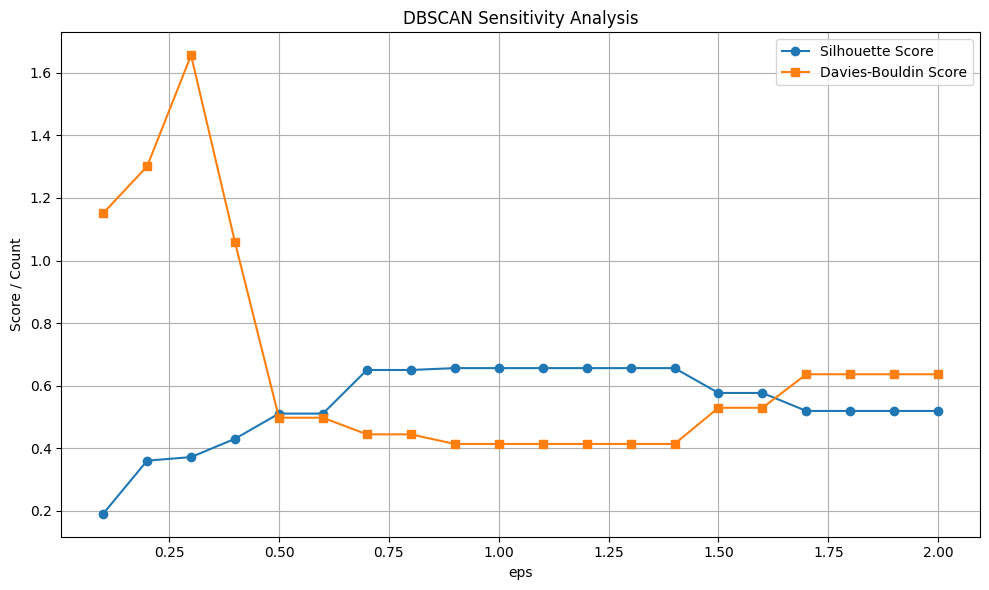

In [56]:
plt.figure(figsize=(10, 6))

plt.plot(df_results['eps'], df_results['silhouette'], label='Silhouette Score', marker='o')
plt.plot(df_results['eps'], df_results['davies_bouldin'], label='Davies-Bouldin Score', marker='s')

plt.xlabel('eps')
plt.ylabel('Score / Count')
plt.title('DBSCAN Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

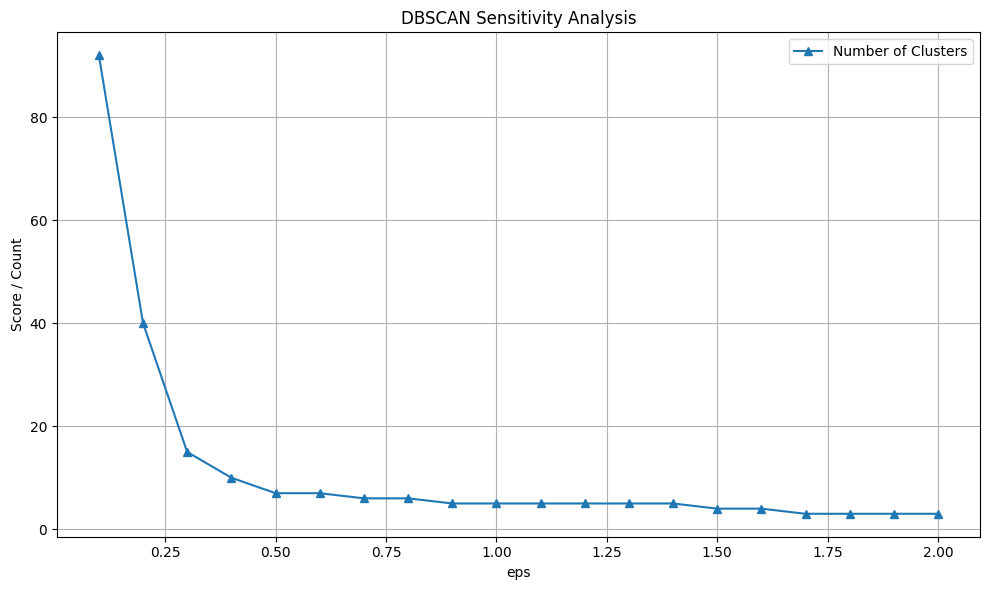

In [57]:
plt.figure(figsize=(10, 6))

plt.plot(df_results['eps'], df_results['n_clusters'], label='Number of Clusters', marker='^')

plt.xlabel('eps')
plt.ylabel('Score / Count')
plt.title('DBSCAN Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
eps_values = np.linspace(0.05, 1.5, 10)
minpts_values = [X_umap.shape[1]+1, 2*X_umap.shape[1]]

results = []
for eps in eps_values:
  for m in minpts_values:
    model = DBSCAN(eps=eps, min_samples=m).fit(X_umap)
    labels = model.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_pct = np.mean(labels == -1)
    if n_clusters > 1:
      sil = silhouette_score(X_umap, labels)
    else:
      sil = np.nan
    results.append((eps, m, n_clusters, noise_pct, sil))

df_results2 = pd.DataFrame(results, columns=['eps', 'm', 'n_clusters','noise_pct','silhouette'])
print(df_results2)

         eps  m  n_clusters  noise_pct  silhouette
0   0.050000  3         322   0.293141    0.101587
1   0.050000  4         225   0.381924    0.010929
2   0.211111  3          21   0.004999    0.248150
3   0.211111  4          22   0.006199    0.441949
4   0.372222  3          10   0.000600    0.357444
5   0.372222  4           9   0.001200    0.437011
6   0.533333  3           7   0.000200    0.510938
7   0.533333  4           7   0.000200    0.510938
8   0.694444  3           6   0.000000    0.650285
9   0.694444  4           6   0.000000    0.650285
10  0.855556  3           6   0.000000    0.650285
11  0.855556  4           6   0.000000    0.650285
12  1.016667  3           5   0.000000    0.656277
13  1.016667  4           5   0.000000    0.656277
14  1.177778  3           5   0.000000    0.656277
15  1.177778  4           5   0.000000    0.656277
16  1.338889  3           5   0.000000    0.656277
17  1.338889  4           5   0.000000    0.656277
18  1.500000  3           4   0

## Analysis

In [93]:
analysis_df = init_df.copy()
analysis_df['cluster'] = labels5
analysis_df

,M1,M18,M18B2,M18B3,M47,IR2,IR4,IR20,IR20B4,IR21,...,EMP_WORK,EMP_STU,EMP_HM,EMP_RET,EMP_OTH,INC_LO,INC_LOAVG,INC_HIAVG,INC_HI,cluster
0,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,0
1,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
2,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,1,0,0,0,1
3,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,0,0,0,0,1,1,0,0,0,2
4,-7,-7,-7,-7,-7,5,-7,-7,-7,-7,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,1,1,-7,-7,5,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
4997,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,1
4998,-7,-7,-7,-7,-7,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,0,1,1
4999,-7,1,-7,-7,5,-7,-7,-7,-7,-7,...,1,0,0,0,0,0,0,1,0,2


In [94]:
demo = demographic()
demo_cols = [d for d in demo if d in analysis_df.columns]
demo_cols

['REGION', 'RESEX', 'AGECAT', 'EDUCAT', 'INC_CAT']

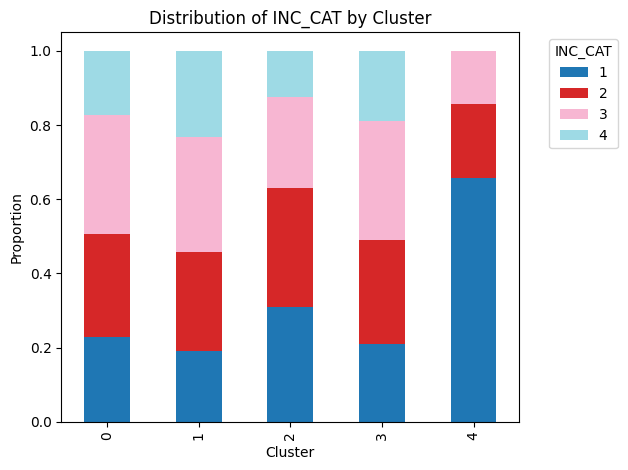

In [95]:
feature = 'INC_CAT'
crosstab = pd.crosstab(analysis_df['cluster'], analysis_df[feature], normalize='index')

crosstab.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f"Distribution of {feature} by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [96]:
def cluster_visual(columns,df,cluster_co_nm = 'cluster'):
    n_features = len(columns)
    n_cols = 4  
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(columns):
        ax = axes[i]
        crosstab = pd.crosstab(df[cluster_co_nm], df[feature], normalize='index')
        crosstab.plot(kind='bar', stacked=True, colormap='tab20', ax=ax, legend=False)
        ax.set_title(f"{feature}")
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Cluster")

    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    handles, labels = ax.get_legend_handles_labels()
    fig.tight_layout(rect=[0, 0, 0.85, 1]) 

    plt.show()

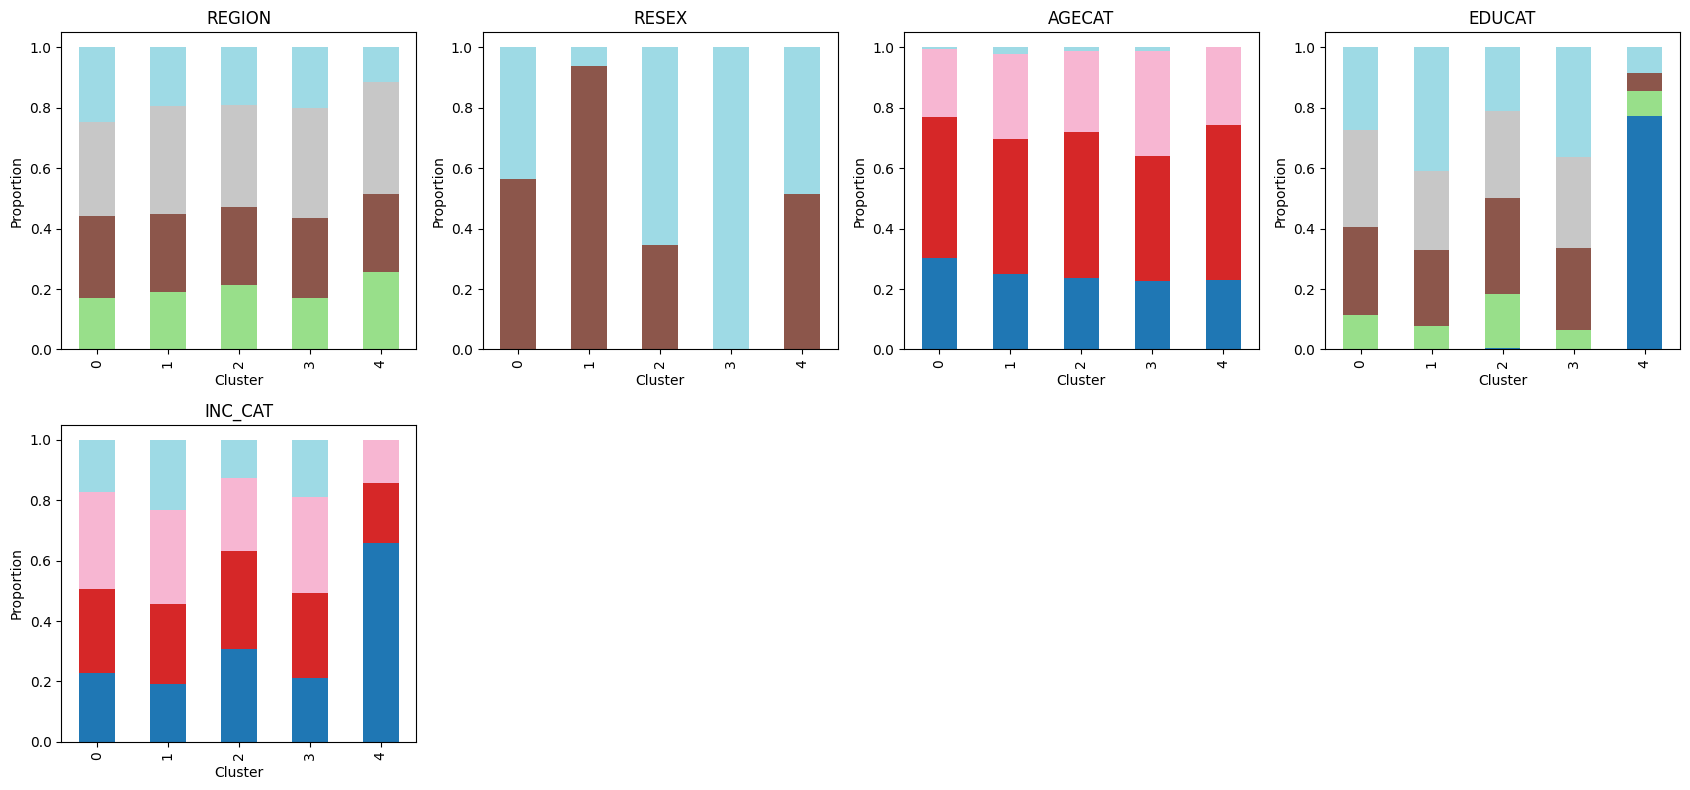

In [97]:
cluster_visual(demo_cols,analysis_df)

In [ ]:
diag = diagnosis()
diag_cols = [d for d in diag if d in analysis_df.columns]

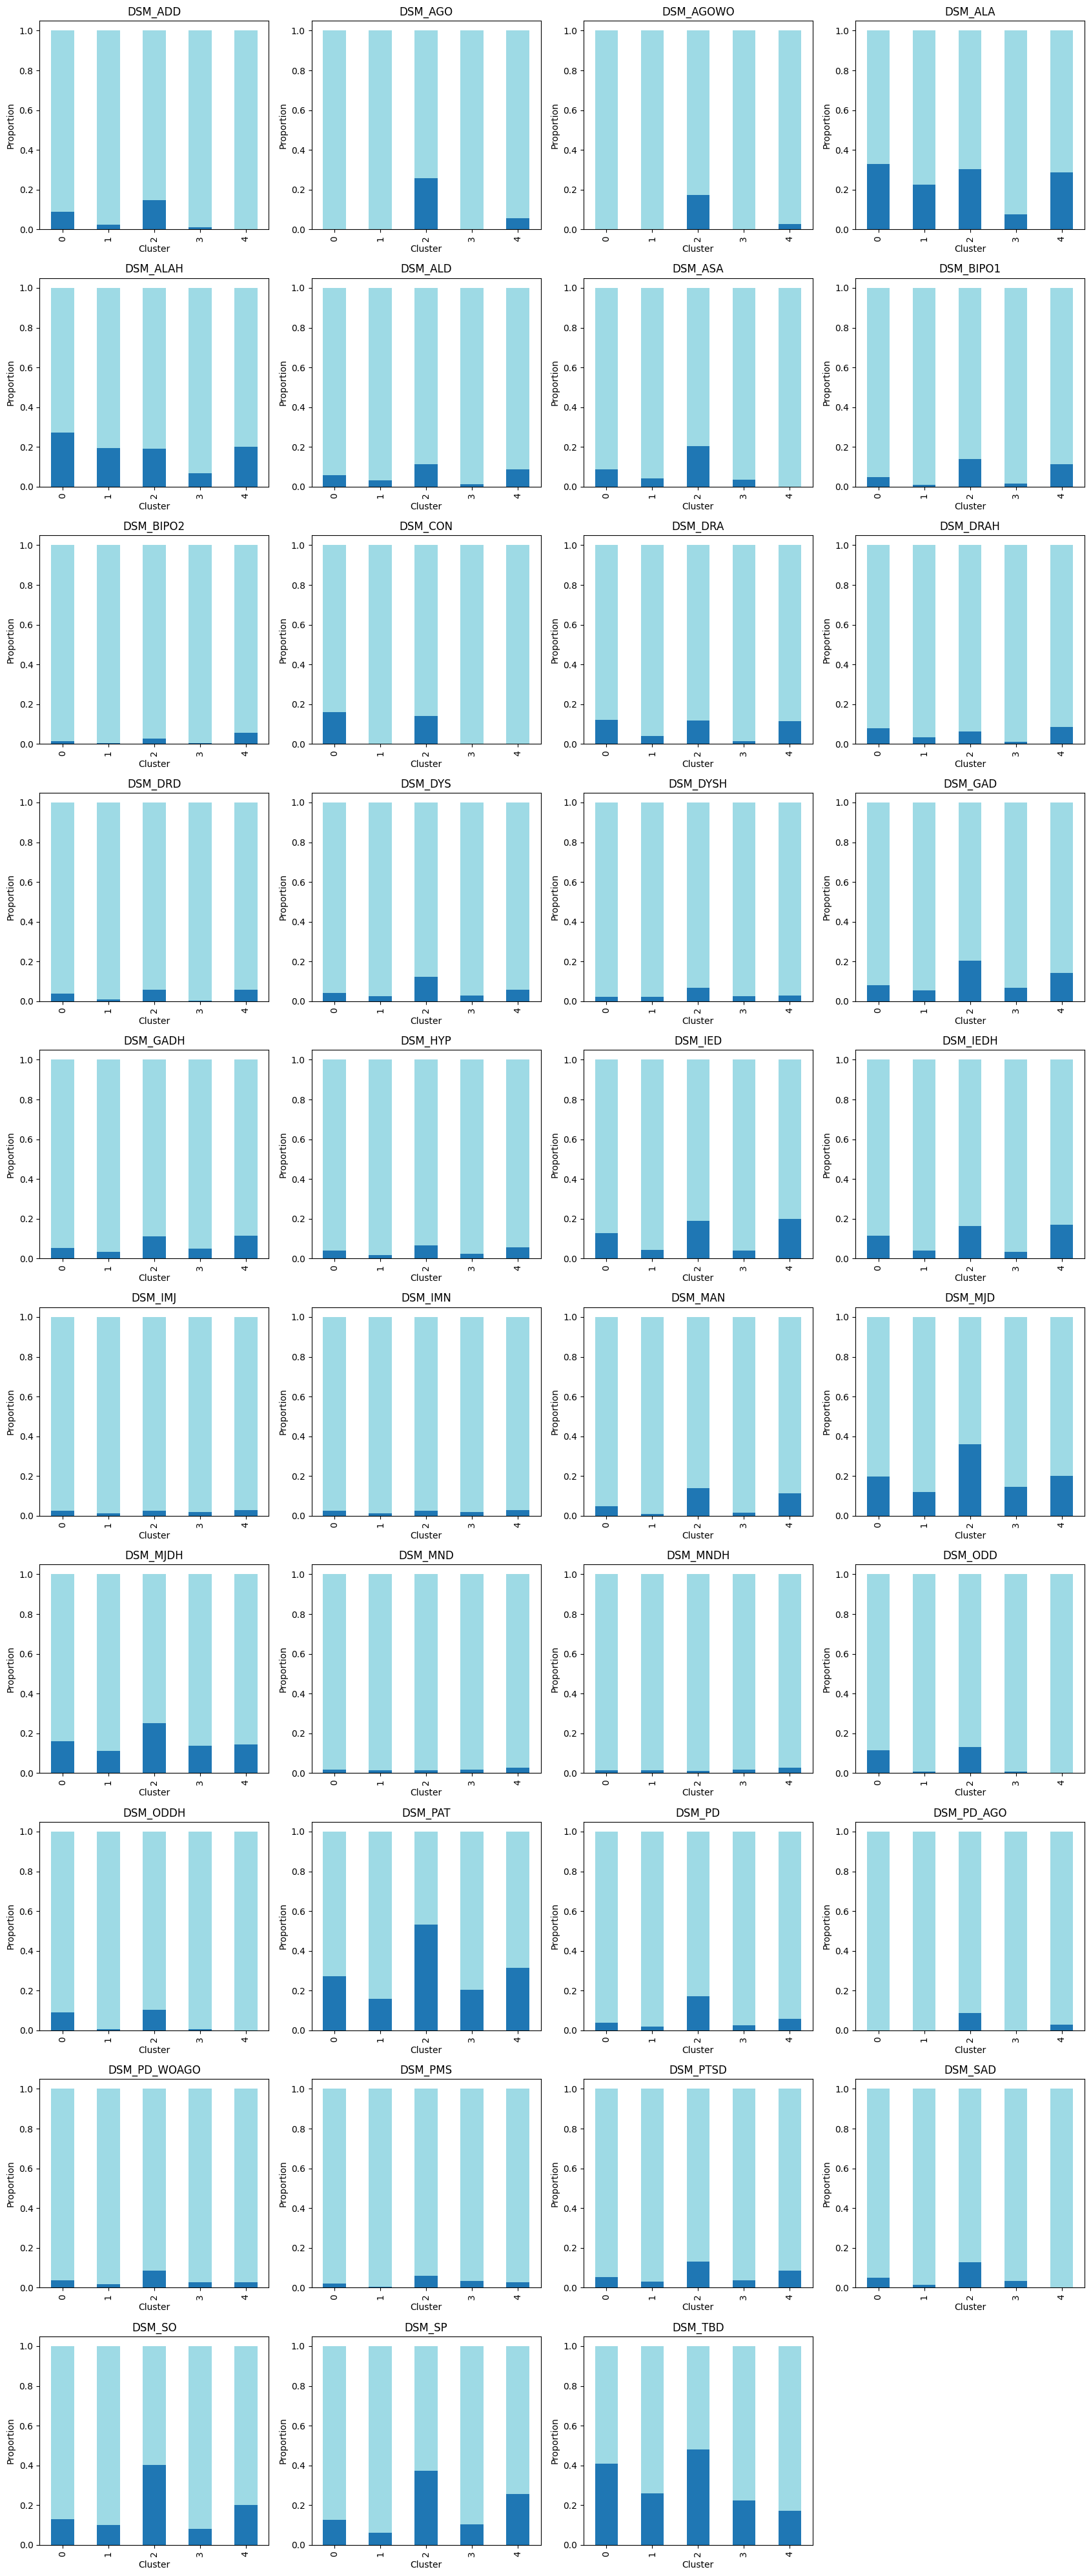

In [98]:
cluster_visual(diag_cols,analysis_df)

In [89]:
child = childhood()
child_cols = [c for c in child if c in analysis_df.columns]

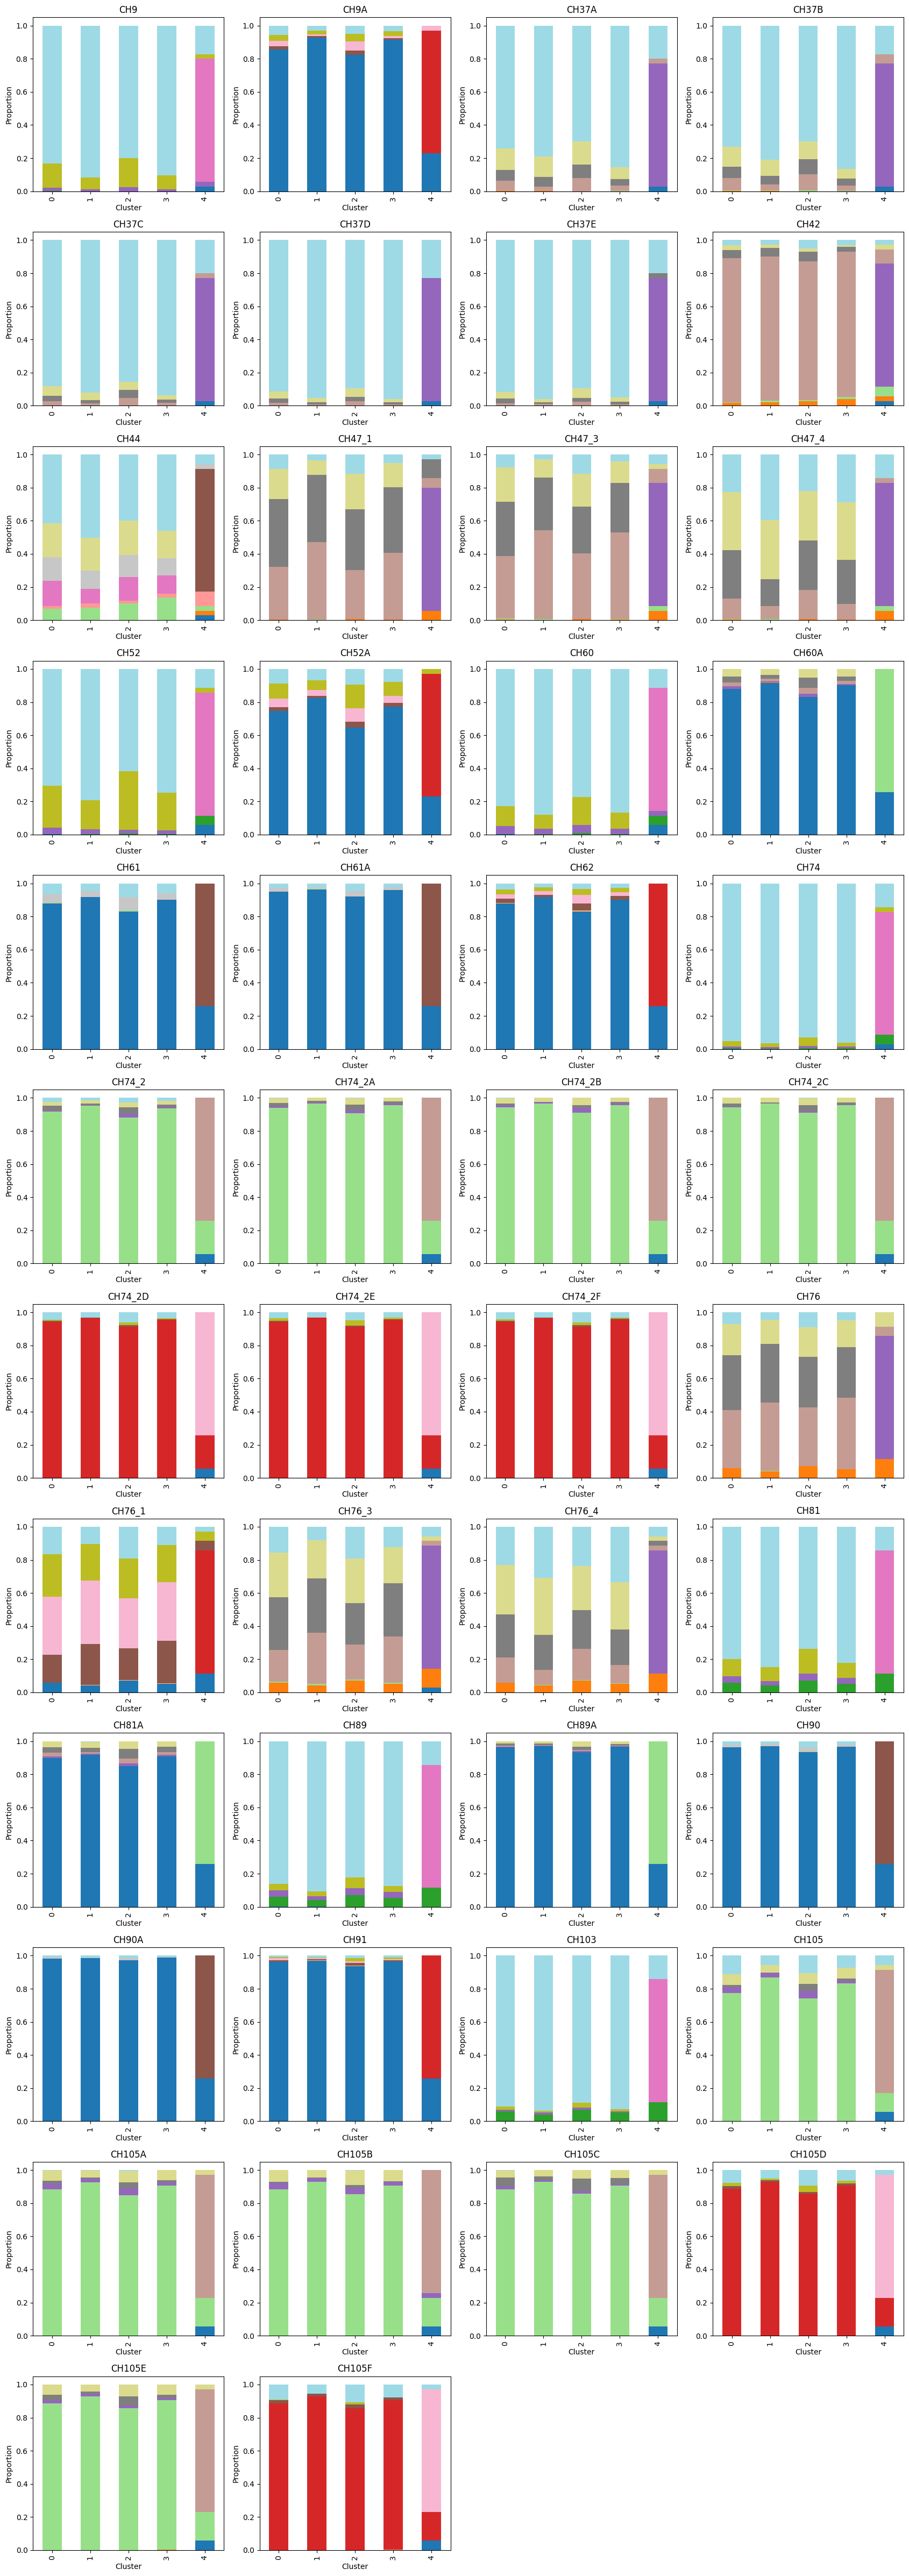

In [99]:
cluster_visual(child_cols,analysis_df)